# Lab 3: KNN and Decision Trees


In this lab we'll get some hands on experience with two of the classifiers we've seen in class
- K Nearest Neighbors
- Decision Trees

## Goals for this lab

- Understand the practical implications for changing the parameters used in KNearest Neighbor Classifier
  - k
  - distance metric
  - weighting method
  
  
- Understand the practical implications for changing the parameters used in Decision Trees

 - splitting criteria (gini vs information gain)
 - max depth
 - min sample size for split
 
- Understand how to interpret Decision Trees

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
import graphviz # If you don't have this, install via pip/conda
%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data
We'll use these classifiers on a small dataset on world happiness metrics:
https://www.kaggle.com/unsdsn/world-happiness/

Download the data from 2015 or 2016 and load it. Note: the 2017 data is missing the Region column so don't use that.

You should also try this with other data sets you have been provided for the homeworks.

In [3]:
# Change this to wherever you're storing your data
dfile = 'world-happiness-report/2015.csv'
df = pd.read_csv(dfile)

In [4]:
df.corr()

,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
Happiness Rank,1.000000,-0.992105,0.158516,-0.785267,-0.733644,-0.735613,-0.556886,-0.372315,-0.160142,-0.521999
Happiness Score,-0.992105,1.000000,-0.177254,0.780966,0.740605,0.724200,0.568211,0.395199,0.180319,0.530474
Standard Error,0.158516,-0.177254,1.000000,-0.217651,-0.120728,-0.310287,-0.129773,-0.178325,-0.088439,0.083981
Economy (GDP per Capita),-0.785267,0.780966,-0.217651,1.000000,0.645299,0.816478,0.370300,0.307885,-0.010465,0.040059
Family,-0.733644,0.740605,-0.120728,0.645299,1.000000,0.531104,0.441518,0.205605,0.087513,0.148117
Health (Life Expectancy),-0.735613,0.724200,-0.310287,0.816478,0.531104,1.000000,0.360477,0.248335,0.108335,0.018979
Freedom,-0.556886,0.568211,-0.129773,0.370300,0.441518,0.360477,1.000000,0.493524,0.373916,0.062783
Trust (Government Corruption),-0.372315,0.395199,-0.178325,0.307885,0.205605,0.248335,0.493524,1.000000,0.276123,-0.033105
Generosity,-0.160142,0.180319,-0.088439,-0.010465,0.087513,0.108335,0.373916,0.276123,1.000000,-0.101301
Dystopia Residual,-0.521999,0.530474,0.083981,0.040059,0.148117,0.018979,0.062783,-0.033105,-0.101301,1.000000


# Some Quick Data Exploration
Before running any sort of model on your dataset, it's always a good idea to do some quick data exploration to get a sense of how your data looks like. Try to answer the following questions with some sort of plot/histogram/etc:

1) What do the distributions of each feature look like?

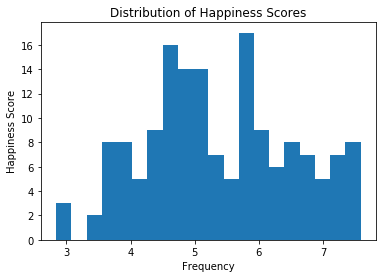

In [5]:
# Ex
plt.hist(df['Happiness Score'], bins=20)
plt.title('Distribution of Happiness Scores')
plt.ylabel('Happiness Score')
plt.xlabel('Frequency')
plt.show()

2) Do countries from the same region have similar feature values? (To save on time so that you're not generating hundreds of plots, you can just pick one or two regions, and look at whichever features look most interesting).

Hint: consider using [pandas' groupby function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) or doing a manual filter

Text(0.5,1,'Family vs Freedom')

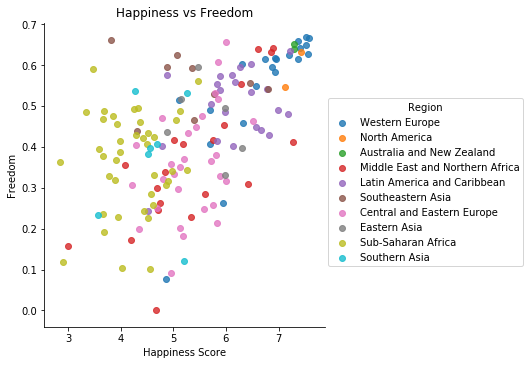

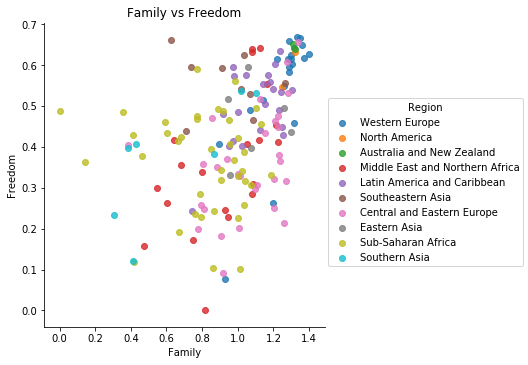

In [6]:
sns.lmplot('Happiness Score', 'Freedom', hue ='Region', fit_reg = False, data = df)
plt.title('Happiness vs Freedom')
sns.lmplot('Family', 'Freedom', hue ='Region', fit_reg = False, data = df)
plt.title('Family vs Freedom')

3) Which features are least correlated with "Happiness"?

Hint: Plotting this is a good idea. Also consider using [pandas' correlation function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html)

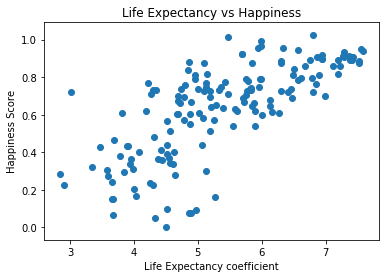

In [7]:
# Example plot
plt.scatter(df['Happiness Score'], df['Health (Life Expectancy)'])
plt.title('Life Expectancy vs Happiness')
plt.xlabel('Life Expectancy coefficient') # units unclear...
plt.ylabel('Happiness Score')
plt.show()

## Classification
A natural thing to do with this dataset is to try to use the various feature columns to predict each country's "Happiness Score" via some regression model. But in this class we're mostly going to focus on classification. So let's create a toy column so that we have a classification task: create a binary 'In Europe' column. We can do this by checking if "Europe" is contained in the "Region" column of each row.

In [8]:
df['In Europe'] = df['Region'].apply(lambda x: 'Europe' in x)

Before we can use any of the classifiers, we need to pick which features we want to drop/keep.

In [9]:
df.drop(['Region', 'Happiness Rank'], axis=1, inplace=True)

# Train/Test Splits

Create a train/test set split using sklearn's [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. We'll use these train/test splits for evaluating all our classification models.

In [10]:
countries = df['Country'] # useful later for reindexing
X = df.drop(['In Europe', 'Country'], axis=1)
Y = df['In Europe']
test_size = 0.3 # you can adjust this
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

# K Nearest Neighbors
See the sklearn documentation on the [KNN classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) to see its parameters. The one's we'll mostly be interested in are:
- n_neighbors
- distance metric
- weighting function

## KNN Distance Function
Something important to note is that the KNN algorithm requires a "metric" or a notion of distance. If you don't set this parameter, it defaults to the Euclidean distance. Do you think the Euclidean distance is appropriate in this setting? You can set the metric parameter to any one of the distance metrics defined under the sklearn [DistanceMetric class](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html)

Different metrics might have different parameters which you can set like so:

In [11]:
# If your metric has a metric parameter you need to pass that in via a
# dictionary to metric_params.
knn = KNeighborsClassifier(n_neighbors=10, metric='minkowski', metric_params={'p': 3})

/Users/claire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  This is separate from the ipykernel package so we can avoid doing imports until


Now let's use the classifier:

In [12]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
knn.predict(x_test)

array([ True, False, False, False, False,  True, False, False, False,
        True,  True, False, False,  True,  True,  True, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False, False,  True,  True, False, False, False, False,  True,
        True,  True, False, False, False,  True,  True, False,  True,
       False,  True, False])

## KNN Tasks:

1) Write a function that computes the accuracy of the predicted values



In [13]:
def check_accuracy(y_actual, y_predict):
    #check = np.where(y_actual == y_predict, y_actual, y_predict)
    #num_true = check.sum()
    #total = len(check)
    #accuracy = num_true/total
    accuracy = metrics.accuracy_score(y_actual, y_predict)
    return accuracy

2) Play around with the n_neighbors value. Fit your data on the training data(x_train, y_train). Then evaluate it on both the training data, and the testing data. How does the accuracy of your train and test set predictions change as you increase n_neighbors?


In [14]:
knn.fit(x_train, y_train)
train_pred = knn.predict(x_train)
test_pred = knn.predict(x_test)
train_acc = check_accuracy(train_pred, y_train)
test_acc = check_accuracy(test_pred, y_test)
train_acc, test_acc

(0.8090909090909091, 0.7708333333333334)

3) The KNeighborsClassifier also has a [predict_proba](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.predict_proba) function. Which countries is the classifier most/least confident about?

In [15]:
knn.predict_proba(x_test) #why all 1s and 0s?

array([[0.2, 0.8],
       [0.8, 0.2],
       [1. , 0. ],
       [0.6, 0.4],
       [0.8, 0.2],
       [0.4, 0.6],
       [1. , 0. ],
       [1. , 0. ],
       [0.8, 0.2],
       [0.2, 0.8],
       [0.4, 0.6],
       [1. , 0. ],
       [1. , 0. ],
       [0.4, 0.6],
       [0.4, 0.6],
       [0.4, 0.6],
       [1. , 0. ],
       [0.6, 0.4],
       [1. , 0. ],
       [0.8, 0.2],
       [0.2, 0.8],
       [0.6, 0.4],
       [0.8, 0.2],
       [0.2, 0.8],
       [0.6, 0.4],
       [0.8, 0.2],
       [0.8, 0.2],
       [0.6, 0.4],
       [1. , 0. ],
       [0. , 1. ],
       [0.4, 0.6],
       [1. , 0. ],
       [0.6, 0.4],
       [1. , 0. ],
       [0.8, 0.2],
       [0.4, 0.6],
       [0.4, 0.6],
       [0.4, 0.6],
       [1. , 0. ],
       [0.8, 0.2],
       [1. , 0. ],
       [0.4, 0.6],
       [0.4, 0.6],
       [1. , 0. ],
       [0.4, 0.6],
       [0.6, 0.4],
       [0.4, 0.6],
       [1. , 0. ]])

4) You can see what datapoints are closest to a given query point via the [kneighbors function](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors). What countries are closest to Switzerland? United States? Your favorite country?

In [16]:
# fix this 
result = knn.kneighbors(x_train, 3, return_distance=False)
Switzerland = 0
United_States = 14
swiss_result = result[Switzerland] 
us_result = result[United_States]
for x in df.index:
    countries.iloc[result[x]]

IndexError: index 110 is out of bounds for axis 0 with size 110

5) Use a different metric for the KNN classifier. Evaluate the train/test set accuracies with the new KNN classifier.

In [ ]:
knn5 = KNeighborsClassifier(n_neighbors=10, metric='minkowski', metric_params={'p': 5})
knn5.fit(x_train, y_train)
train_pred = knn5.predict(x_train)
test_pred = knn5.predict(x_test)
train_acc = check_accuracy(train_pred, y_train)
test_acc = check_accuracy(test_pred, y_test)
train_acc, test_acc

6) Use a different weighting function for the KNN classifier. Evaluate the train/test set accuracies with the new KNN classifier.

In [ ]:
knn5 = KNeighborsClassifier(n_neighbors=3, weights = 'distance', metric='minkowski', metric_params={'p': 5})
knn5.fit(x_train, y_train)
train_pred = knn5.predict(x_train)
test_pred = knn5.predict(x_test)
train_acc = check_accuracy(train_pred, y_train)
test_acc = check_accuracy(test_pred, y_test)
train_acc, test_acc

## Now write a nested for loop that loops over all the parameters and values and store the results in a data frame

### pseudocode

- for k in 1,2,3,4,5...10
  - for distance metric in (metric1, metric2,...)
    - for weighting function in (uniform, distance weighted)
      - train model
      - score test data
      - evaluate - calculate metrics
      - store parameters and evaluation metric in data frame
- print dataframe


     

In [31]:
df2 = pd.DataFrame(columns = ['num_neighbors', 'metric', 'weighting_function', 'training_acc', 'test_acc'])
i = 0
for k in range(1,6):
    for metric in ['minkowski','euclidean']:
        for func in ['uniform', 'distance']:
            params = [k, metric, func]
            model = KNeighborsClassifier(n_neighbors=k, weights=func, metric=metric)
            model.fit(x_train, y_train)
            train_pred = model.predict(x_train)
            test_pred = model.predict(x_test)
            train_acc = check_accuracy(y_train, train_pred)
            test_acc = check_accuracy(y_test, test_pred)
            tup = [k, metric, func, train_acc, test_acc]
            df2.loc[i] = tup
            i += 1

In [32]:
df2

,num_neighbors,metric,weighting_function,training_acc,test_acc
0,1,minkowski,uniform,1.000000,0.812500
1,1,minkowski,distance,1.000000,0.812500
2,1,euclidean,uniform,1.000000,0.812500
3,1,euclidean,distance,1.000000,0.812500
4,2,minkowski,uniform,0.809091,0.791667
5,2,minkowski,distance,1.000000,0.812500
6,2,euclidean,uniform,0.809091,0.791667
7,2,euclidean,distance,1.000000,0.812500
8,3,minkowski,uniform,0.854545,0.791667
9,3,minkowski,distance,1.000000,0.791667


###  You cn now use this data frame to analyze the results and see how the model performs as you modify the parameters

# Decision Trees

Moving onto decision trees. The [DecisionTreeClassifier constructor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) can take a number of parameters. You should look at all the available 
- criterion: string, "gini' for Gini Impurity or 'entropy' for information gain
- splitter: string,  "best" or 'random'
- max_features: the number of features to consider when looking for the best split.
- max_depth: int, the maximum depth of the tree.
- min_samples_split: minimum number of samples required to split an internal node
- min_samples_leaf: min number of samples required to be at a leaf node.
- max_leaf_nodes: max number of leaf nodes a tree can have

We can do the same fit/predict/predict_proba:

In [ ]:
dec_tree = DecisionTreeClassifier()
dec_tree.fit(x_train, y_train)
# dec_tree.predict(x_train)
# dec_tree.predict_proba(y_train)

We'll be interested in how each of these parameters will affect the performance of a Decision Tree classifier.

For example: Increasing max_depth this should increase your model's ability to explain the data and eventually overfit the training data once it's high enough. The performance on the test set should degrade a bit as the training set is overfitted.

In [ ]:
from sklearn.metrics import accuracy_score as accuracy

In [ ]:
depths = [1, 3, 5, 7, 9]
for d in depths:
    dec_tree = DecisionTreeClassifier(max_depth=d)
    dec_tree.fit(x_train, y_train)
    train_pred = dec_tree.predict(x_train)
    test_pred = dec_tree.predict(x_test)
    # evaluate accuracy
    train_acc = accuracy(train_pred, y_train)
    test_acc = accuracy(test_pred, y_test)
    
    print("Depth: {} | Train acc: {:.2f} | Test acc: {:.2f}".format(d, train_acc, test_acc))

## Decision Tree Tasks
1) Repeat the above with each parameter in DecisionTreeClassifier. What range of values makes sense for each parameter?
(IE: does it make sense to have max_depth greater than 7 or 8 for this dataset?)

In [ ]:
# CODE

2) What do you think will happen if you normalize/scale one of the features of your dataset before passing it into the DecisionTreeClassifier.fit function? Try modifying one of your columns and rerun the evaluations above.
Do the results change? Why does/doesnt this change the resulting model?

In [ ]:
# CODE

3) How does changing the "criterion" parameter affect your model. Is Gini better than Information Gain? Do not change the other parameters(max_depth, min_sample_split, etc) while doing this.

In [ ]:
# CODE

4) Decision Trees are widely used in practice because they're very interpretable. Check out the [feature_importances](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_) attribute of the DecisionTreeClassifier. What features are the most informative according to this model?

In [ ]:
# CODE

## Visualizing a Decision Tree
We can visualize decision trees by exporting the model in graphviz format using the [sklearn.tree.export_graphviz function](http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html). This can be very useful in diagnosing potential issues with your Decision Tree Classifier giving you poor results.

In [ ]:
dec_tree = DecisionTreeClassifier(max_depth=3)
dec_tree.fit(x_train, y_train)
viz = tree.export_graphviz(dec_tree, feature_names=x_train.columns,
                           class_names=['Europe', 'Not Europe'],
                           rounded=True, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()
    graph = graphviz.Source(dot_graph)
graph

You should see something like:

![Decision Tree visualized](imgs/dt.png)

5) Visualize the decision tree of your best performing decision tree. Is there anything surprising about the splits that are most informative of this classification task?

In [ ]:
# CODE

## Now write a nested for loop that loops over all the parameters and values and store the results in a data frame




In [ ]:
# CODE

# References
http://scikit-learn.org/stable/modules/neighbors.html#classification
    
http://scikit-learn.org/stable/modules/tree.html#tree